<a href="https://colab.research.google.com/github/mohiiieldin/Advance-Data-Analysis-Nano-Degree-by-Udacity-/blob/main/Practical%20Statistics/Analyze_ab_test_results_notebook_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#On Progress!

## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
ab_data = pd.read_csv("/content/drive/MyDrive/Udacity Nano-degree projects data/ab_data.csv")
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [ ]:
ab_data.shape[0]

294478

c. The number of unique users in the dataset.

In [ ]:
ab_data.user_id.nunique()

290584

d. The proportion of users converted.

In [ ]:
print(round(ab_data.converted.mean() * 100 , 2) , "%")

11.97 %


e. The number of times the `new_page` and `treatment` don't line up.

In [ ]:
ab_data[(ab_data.landing_page == "old_page") & (ab_data.group == "treatment")].shape[0] + ab_data[(ab_data.landing_page == "new_page") & (ab_data.group == "control")].shape[0]


3893

f. Do any of the rows have missing values?

In [ ]:
ab_data.isnull().any(axis = 1).sum()

0

No missing data

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [4]:
df2 = ab_data.drop(ab_data[(ab_data.landing_page == "old_page") & (ab_data.group == "treatment")].index)
df2 = df2.drop( df2[(df2.landing_page == "new_page") & (df2.group == "control")].index)

In [ ]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [ ]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [ ]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [5]:
print(df2.shape[0])
df2 = df2.drop(2893)
print(df2.shape[0])

290585
290584


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [ ]:
print( round(df2.converted.mean() * 100 , 2) , "%")

11.96 %


b. Given that an individual was in the `control` group, what is the probability they converted?

In [ ]:
print( round(df2[df2.group == "control"].converted.mean() * 100 , 2) , "%")

12.04 %


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [ ]:
print( round(df2[df2.group == "treatment"].converted.mean() * 100 , 2) , "%")

11.88 %


d. What is the probability that an individual received the new page?

In [ ]:
print(round( df2[df2.landing_page == "new_page"].shape[0] / df2.shape[0] * 100 ,2) , "%")

50.01 %


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

From the probabilities above i see no significant difference

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0:P_old=P_new**

**H1:P_new>P_old**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [6]:
p_null = df2['converted'].mean()
p_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [7]:
p_null

0.11959708724499628

c. What is $n_{new}$?

In [8]:
n_new = df2.query("landing_page == 'new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [9]:
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [11]:
new_page_converted = np.random.binomial(1, p_null, n_new)
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [12]:
old_page_converted = np.random.binomial(1, p_null, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [13]:
new_page_converted.mean() - old_page_converted.mean()

0.00033509468343705107

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [15]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_null, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_null, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs

array([ 1.53277169e-03, -2.21844441e-03, -8.83272175e-04, ...,
       -1.48869834e-03,  8.06712915e-05, -1.15837690e-03])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  17.,  164.,  735., 1858., 2860., 2587., 1302.,  404.,   69.,
           4.]),
 array([-0.00431038, -0.00341084, -0.0025113 , -0.00161176, -0.00071222,
         0.00018732,  0.00108686,  0.0019864 ,  0.00288594,  0.00378548,
         0.00468502]),
 <a list of 10 Patch objects>)

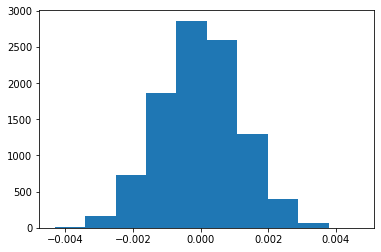

In [16]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [19]:
treatment_prob = df2[df2.group == "treatment"].converted.mean()
control_prob = df2[df2.group == "control"].converted.mean()

0.19119999999999998


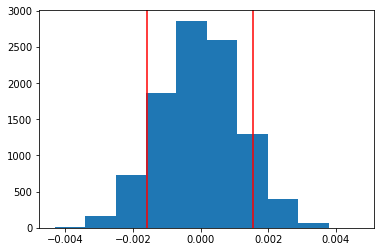

In [20]:
obs_diff = treatment_prob - control_prob

low_prob = (p_diffs < obs_diff).mean()
high_prob = (p_diffs.mean() + (p_diffs.mean() - obs_diff) < p_diffs).mean()

plt.hist(p_diffs);
plt.axvline(obs_diff, color='red');
plt.axvline(p_diffs.mean() + (p_diffs.mean() - obs_diff), color='red');

p_val = low_prob + high_prob
print(p_val)

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

I just cpmouted the P-Value which represent the probability that the difference between the treatment and control is just a random effect and it can be happened normally and since it's too big (greater than 5% in our case) hence we can say that there is no significant difference between the converte rate in the control and treatment


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [22]:
import statsmodels.api as sm
convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum() 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
print(z_score, p_value)

In [24]:
z_score, p_value = sm.stats.proportions_ztest([convert_old , convert_new] , [n_old , n_new])
print("z_score: ",z_score , "\n p_value: " , p_value)

z_score:  1.3109241984234394 
 p_value:  0.18988337448195103


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Yes, they are almost the same

Z_score means the (difference between the old and new conversion rate) and the null hypothesis is 1.31 standard deviations units which didn't reach the 1.96 value to be able to reject the null hypothesis 

P-value is not below 0.05 hence the ruslted value in the treatment can be happens from the random chance in the data and we can not reject the null  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [26]:
df2['intercept'] = 1
df2[['_', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('_', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [28]:
model = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page']])
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [30]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 May 2021   Pseudo R-squ.:               8.077e-06
Time:                        17:59:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.190 here, which is similar to the previous values, but slightly higher. This model is attempting to predict whether a user will convert depending on their page. The null hypothesis is that when ab_page = 1, converted = 0; the alternative hypothesis is that when ab_page = 1, converted is more likely to be 1.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It seems that there is no big impace for the page layout so mabye we need to add more feature like the orders history of the client the popularity of the item the price of the item and so on and start to see the imapct of each feature on predicting if the customer will convert or no

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [31]:
countries = pd.read_csv('/content/drive/MyDrive/Udacity Nano-degree projects data/countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [32]:
countries_new = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
countries_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [35]:
countries_new[['CA', 'UK', 'US']] = pd.get_dummies(countries_new['country'])

In [37]:
countries_new.drop("country" , axis = 1 , inplace = True)
countries_new.head()

,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
### Fit Your Linear Model And Obtain the Results
model = sm.Logit( countries_new['converted'] , countries_new[['intercept' , 'ab_page', 'CA','UK']] )
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 May 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:14:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [ ]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Based on the p-values above, it also does not appear as though country has a significant impact on conversion.



we do not have enough evidence to reject the null hypothesis based on any of our A/B testing. As a result, there is no reason to switch to the new page, when the old one performs just as well.
